<a href="https://colab.research.google.com/github/KangHyeonGu1/-/blob/main/solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import scipy.stats as stats
data = pd.read_csv("solar.txt")
data.head
data=data.rename(columns={'cloud cover':'cloudcover'})


In [3]:
rm = ols(' day_power~ temp + humidity', data=data).fit()
rm.summary()
rm.params

Intercept    0.609884
temp         0.494987
humidity    -0.830676
dtype: float64

In [4]:
rm = ols(' humidity~ temp + cloudcover + temp*cloudcover', data=data).fit()
rm.summary()
rm.params

Intercept          0.727877
temp              -0.453094
cloudcover         0.023300
temp:cloudcover    0.008920
dtype: float64

In [5]:
# 독립변수 기온 spread설정과 삼각퍼지화
te=data['temp']
spread= [None] * 1332
for i in range(0,1331):
  spread[i]= (np.abs(te[i+1]-te[i]))/2
spread[1331]=spread[1330]
x1= te-spread
x2= te+spread
xdf=pd.DataFrame({'a':x1,'b':te,'c':x2})
xa=xdf[xdf['a']< 0]
xdf.loc[xa.index,'a']=0
x=xdf.to_numpy()

In [6]:
hu=data['humidity']
spreadm= [None] * 1332
for i in range(0,1331):
  spreadm[i]= (np.abs(hu[i+1]-hu[i]))/2
spreadm[1331]=spreadm[1330]
m1= hu-spreadm
m2= hu+spreadm
mdf=pd.DataFrame({'a':m1,'b':hu,'c':m2})
ma=mdf[mdf['a']< 0]
mdf.loc[ma.index,'a']=0
m=mdf.to_numpy()

In [7]:
# 종속변수
power=data['day_power']
ydf=pd.DataFrame({'a':power,'b':power,'c':power})
y= ydf.to_numpy()


In [8]:
# 조절변수1
cl=data['cloudcover']
w1= cl-1
w2= cl+1
wdf=pd.DataFrame({'a':w1,'b':cl,'c':w2})
wa=wdf[wdf['a']< 1]
wdf.loc[wa.index,'a']=1
wc=wdf[wdf['c']> 8]
wdf.loc[wc.index,'c']=8
w=wdf.to_numpy()

In [9]:
# 조절변수2
wi=data['wind']
spreadz= [None] * 1332
for i in range(0,1331):
  spreadz[i]= (np.abs(wi[i+1]-wi[i]))/2
spreadz[1331]=spreadz[1330]
z1= wi-spreadz
z2= wi+spreadz
zdf=pd.DataFrame({'a':z1,'b':wi,'c':z2})
za=zdf[zdf['a']< 0]
zdf.loc[za.index,'a']=0
z=zdf.to_numpy()

In [10]:
ones=np.ones(shape=(1332,3))
def dc(a,b):          
  c=a*b
  sum=c.sum()
  return sum

In [11]:
def freg(data):
  te=data['temp']
  spread= [None] * 1332
  for i in range(0,1331):
    spread[i]= (np.abs(te.iloc[i+1]-te.iloc[i]))/2
  spread[1331]=spread[1330]
  x1= te-spread
  x2= te+spread
  xdf=pd.DataFrame({'a':x1,'b':te,'c':x2})
  xa=xdf[xdf['a']< 0]
  xdf.loc[xa.index,'a']=0
  x=xdf.to_numpy()

  hu=data['humidity']
  spreadm= [None] * 1332
  for i in range(0,1331):
    spreadm[i]= (np.abs(hu.iloc[i+1]-hu.iloc[i]))/2
  spreadm[1331]=spreadm[1330]
  m1= hu-spreadm
  m2= hu+spreadm
  mdf=pd.DataFrame({'a':m1,'b':hu,'c':m2})
  ma=mdf[mdf['a']< 0]
  mdf.loc[ma.index,'a']=0
  m=mdf.to_numpy()

  power=data['day_power']
  ydf=pd.DataFrame({'a':power,'b':power,'c':power})
  y= ydf.to_numpy()

  cl=data['cloudcover']
  w1= cl-1
  w2= cl+1
  wdf=pd.DataFrame({'a':w1,'b':cl,'c':w2})
  wa=wdf[wdf['a']< 1]
  wdf.loc[wa.index,'a']=1
  wc=wdf[wdf['c']> 8]
  wdf.loc[wc.index,'c']=8
  w=wdf.to_numpy()
  xw=x*w

  xtx=np.zeros(shape=(4,4))
  xlist=[ones,x,w,xw]
  for i in range(0,4):   
    for j in range(0,4):
      xtx[i,j]= dc(xlist[i],xlist[j])
  xtm=np.zeros(shape=(4,1))   
  for i in range(0,4):   
    for j in range(0,1):
      xtm[i,j]= dc(xlist[i],m)
  lxtx=np.linalg.inv(xtx)
  b=lxtx@xtm
  b=np.around(b, decimals=4)

  xtx2=np.zeros(shape=(3,3))
  xlist2=[ones,x,m]
  for i in range(0,3):   
    for j in range(0,3):
      xtx2[i,j]= dc(xlist2[i],xlist2[j])
  xty=np.zeros(shape=(3,1))   
  for i in range(0,3):   
    for j in range(0,1):
      xty[i,j]= dc(xlist2[i],y)
  lxtx2=np.linalg.inv(xtx2)
  b2=lxtx2@xty
  b2=np.around(b2, decimals=4)
  return b, b2

In [12]:
para=freg(data)
para

(array([[ 0.7014],
        [-0.4756],
        [ 0.0273],
        [ 0.0188]]), array([[ 0.5432],
        [ 0.5348],
        [-0.7551]]))

In [13]:
# sea1
x_m=x.sum(axis=0)/1332
x_m
d2=(x-x_m)**2
sda1=np.sqrt(d2.sum()/1331)
sea1=sda1/np.sqrt(1332)
sea1

0.00889794270774266

In [14]:
# seb
m_m=m.sum(axis=0)/1332
m_m
d2=(m-m_m)**2
sdb=np.sqrt(d2.sum()/1331)
seb=sdb/np.sqrt(1332)
seb

0.0077108953758481605

In [15]:
# sea2
w_m=w.sum(axis=0)/1332
w_m
d2=(w-w_m)**2
sda2=np.sqrt(d2.sum()/1331)
sea2=sda2/np.sqrt(1332)
sea2

0.06006941551329541

In [17]:
# a1의 95% 신뢰구간과 z값 검정
a1=para[0][1]
CI=[a1-1.96*sea1,a1+1.96*sea1]
z=a1/sea1
p = 2 * (1 - stats.norm.cdf(np.abs(z)))
print(CI,p)

[array([-0.49303997]), array([-0.45816003])] [0.]


In [18]:
# a2의 95% 신뢰구간과 z값 검정
a2=para[0][2]
CI=[a2-1.96*sea2,a2+1.96*sea2]
z=a2/sea2
p = 2 * (1 - stats.norm.cdf(np.abs(z)))
print(CI,p)


[array([-0.09043605]), array([0.14503605])] [0.64948755]


In [53]:
# a3의 95% 신뢰구간과 z값 검정      sea1 가지고 구함
a3=para[0][3]
CI=[a3-1.96*sea1,a3+1.96*sea1]
z=a3/sea1
p = 2 * (1 - stats.norm.cdf(np.abs(z)))
print(CI,p)

[array([0.00136003]), array([0.03623997])] [0.03461378]


In [20]:
# b의 95% 신뢰구간과 z값 검정
b=para[1][2]
CI=[b-1.96*seb,b+1.96*seb]
z=b/seb
p = 2 * (1 - stats.norm.cdf(np.abs(z)))
print(CI,p)
print(para[0][1].astype('float64'))
para[0][1]
a=[para[0][1].astype('float64')]
a

[array([-0.77021335]), array([-0.73998665])] [0.]
[-0.4756]


[array([-0.4756])]

In [31]:
#부트스트랩 표본
a1_boot=[None]*5000
a2_boot=[None]*5000
a3_boot=[None]*5000
b_boot=[None]*5000
c_boot=[None]*5000
for i in range(0,5000):
  new_data=data.sample(n=1332,replace=True)
  parameters=freg(new_data)
  a1_boot[i]= parameters[0][1]
  a2_boot[i]= parameters[0][2]
  a3_boot[i]= parameters[0][3]
  b_boot[i]= parameters[1][2]
  c_boot[i]= parameters[1][1]

In [36]:
np.save('a1_boot',a1_boot)
np.save('a2_boot',a2_boot)
np.save('a3_boot',a3_boot)
np.save('b_boot',b_boot)
np.save('c_boot',c_boot)

In [38]:
a1_boot=np.load('a1_boot.npy')
a2_boot=np.load('a2_boot.npy')
a3_boot=np.load('a3_boot.npy')
b_boot=np.load('b_boot.npy')
c_boot=np.load('c_boot.npy')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


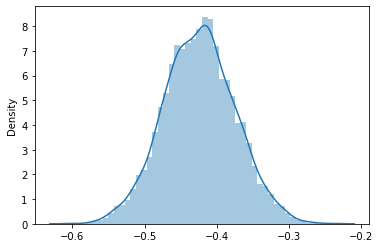

In [39]:
sns.distplot(a1_boot)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


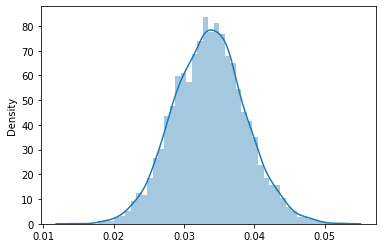

In [41]:
sns.distplot(a2_boot)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


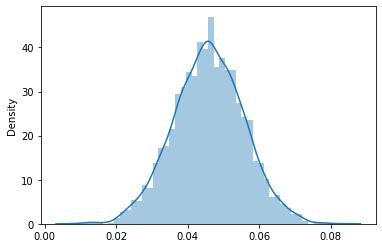

In [42]:
sns.distplot(a3_boot)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


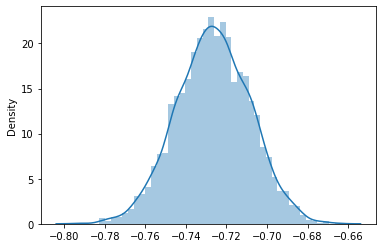

In [43]:
sns.distplot(b_boot)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


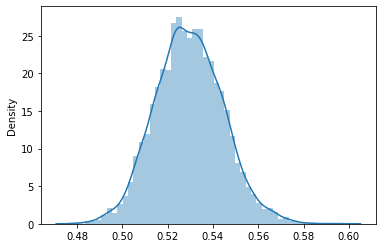

In [44]:
sns.distplot(c_boot)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


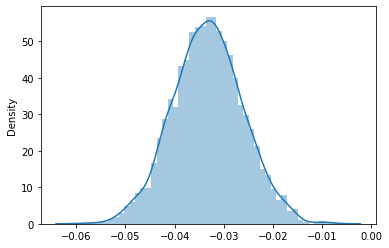

In [46]:
a3_ar=np.array(a3_boot)
b_ar=np.array(b_boot)
a3b_boot=a3_ar*b_ar
sns.distplot(a3b_boot)

In [70]:
# a1에 대한 부트스트랩 신뢰구간
a1_boot.sort()
al=np.abs((a1_boot[124]+ a1_boot[125])/2)
au=np.abs((a1_boot[4873]+a1_boot[4874])/2)
a1cl=[a1- al*sea1,a1 + au*sea1]
a1cl

[array([-0.47922814]), array([-0.47139928])]

In [69]:
# a2에 대한 부트스트랩 신뢰구간
a2_boot.sort()
al=(a2_boot[124]+ a2_boot[125])/2
au=(a2_boot[4873]+a2_boot[4874])/2
a2cl=[a2- al*sea2,a2 + au*sea2]
print(a2)
a2cl

[0.0273]


[array([0.02494828]), array([0.02915014])]

In [72]:
# a3에 대한 부트스트랩 신뢰구간
a3_boot.sort()
al=np.abs((a3_boot[124]+ a3_boot[125])/2)
au=np.abs((a3_boot[4873]+a3_boot[4874])/2)
a3cl=[a3- al*sea1,a3 + au*sea1]
a3cl

[array([0.01844364]), array([0.01930451])]

In [73]:
# b에 대한 부트스트랩 신뢰구간
b_boot.sort()
bl=np.abs((b_boot[124]+ b_boot[125])/2)
bu=np.abs((b_boot[4873]+b_boot[4874])/2)
bcl=[b- bl*seb,b + bu*seb]
bcl

[array([-0.7605624]), array([-0.74961061])]

In [75]:
# c에 대한 부트스트랩 신뢰구간
c=para[1][1]
c_boot.sort()
cl=np.abs((c_boot[124]+ c_boot[125])/2)
cu=np.abs((c_boot[4873]+c_boot[4874])/2)
ccl=[c- cl*sea1,c + cu*sea1]
ccl

[array([0.53003026]), array([0.53958264])]